""" FORT drop recapture experiment 
Preston Huft, August 2019

Physics based on code by Mark Saffman
""" 

In [1]:
# %matplotlib notebook

## libraries
from matplotlib import pyplot as plt
import numpy as np
from numpy import linspace,empty,sin,cos,log,exp,sqrt
from numpy.random import normal
import math as m
from math import pi,e
from random import random as rand
# from scipy.integrate import solve_ivp

## other files
from physconsts import *
from rbconsts import *
from rbensemble import RbEnsemble as ensemble

## make the display wide
from IPython.core.display import display,HTML
display(HTML("<style>.container{width:100% !important;}</style>"))

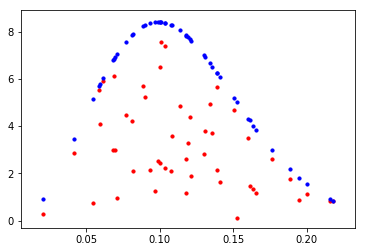

array([0.07095665, 0.1635503 , 0.15074276, 0.08146923, 0.10803242,
       0.11378582, 0.19459407, 0.11798936, 0.09995086, 0.05936611,
       0.10055564, 0.19988805, 0.05873636, 0.2180334 , 0.21579042,
       0.11891259, 0.1339803 , 0.09015447, 0.12988032, 0.13910878,
       0.16104152, 0.02027206, 0.04185641, 0.11764256, 0.15243752,
       0.1036527 , 0.06141105, 0.12140649, 0.17621725, 0.18854024,
       0.14099773, 0.05448405, 0.09697018, 0.06824839, 0.09344427,
       0.16024084, 0.07681745, 0.13867687, 0.1035944 , 0.06888161,
       0.09870602, 0.12030209, 0.08082973, 0.08840488, 0.06950562,
       0.16569498, 0.1310553 , 0.10017037, 0.10748086, 0.13584459])

In [2]:
# maxwboltz test
atoms = ensemble(5e-5)
atoms.sampling_maxboltzv(50,[0,1],showplot=True)

In [14]:


def drop_recap(wx,Tdepth,Tatom,tmax,steps=None,events=None,
               wy=None,base_retention=None):
    """ Based on code by Mark, with some corrections
        'wx': waist
        'Tdepth': FORT temperature depth
        'T': atom temp
        'tmax': max time in units us
        'steps': number of FORT drop outs
        'events': number of release-recapture events per data pt
        'wy': optional waist for eliptical FORT 
    """
    
    global mRb,kB,g
    
    if steps is None:
        steps = 100
    if events is None:
        events = 2000
    if wy is None:
        wy = wx
    if base_retention is None:
        base_retention = .95 # the retention baseline with no fort drop
        
    T = Tatom
    tmax = tmax*1e-6 # [us]->[s]
    umax = kB*Tdepth # the maximum FORT depth
            
    tlist = linspace(0,tmax,steps) # time in units s
    retention = empty(steps)
    
    lmbda = 1.064e-6 # the trap wavelength
    
    zR = pi*wx**2/lmbda
    omega_r = (1/sqrt((wx**2+wy**2)/2))*sqrt(2*kB*Tdepth/mRb)
    omega_z = (1/zR)*sqrt(2*kB*Tdepth/mRb)
    print(f"omega_r = {omega_r*1e-3:.3f} kHz, omega_z = {omega_z*1e-3:.3f} kHz")
    
    def U(x,y,z):
        """ the potential energy as a function of space in the trap """
        ww = (1+z**2/zR**2) 
        return -umax*exp(-2*x**2/(wx**2*ww)-2*y**2/(wy**2*ww))/ww # idk if i trust this expression
    

    # generate random atom coordinates within the trap - Mark approach
#     zlist = normal(0,pi*wx**2/(sqrt(2)*lmbda)*sqrt(T),size=events)
#     xlist = [normal(0,.5*wx*sqrt(1+z**2/zR**2)*sqrt(T))
#               for z in zlist]
#     ylist = [normal(0,.5*wy*sqrt(1+z**2/zR**2)*sqrt(T))
#               for z in zlist]

    # generate random atom coordinates within the trap - Grangier group approach
    dx = dy = sqrt(kB*T/(mRb*omega_r**2))
    dz = sqrt(kB*T/(mRb*omega_z**2))
    zlist = normal(0,dz,size=events)
    xlist = normal(0,dx,size=events)
    ylist = normal(0,dy,size=events)
    
    # maxwell boltzmann speeds
    atoms = ensemble(T)
    vxlist = atoms.sampling_maxboltzv(events,[0,2])
    vylist = atoms.sampling_maxboltzv(events,[0,2])
    vzlist = atoms.sampling_maxboltzv(events,[0,2])

#     print(f"vx={vxlist}")
    
    # run the experiment
    for j,t in enumerate(tlist):
        
        escape = 0 
        nhot = 0 # this is an untrapped atom
        
        if j % 10 == 0:
            print(f"timestep {j}: t = {t*1e6:.0f} [us],")
            
        for i in range(events):     
            hot = 0
            KE = .5*mRb*((vxlist[i]-g*t)**2+vylist[i]**2
                          +vzlist[i]**2)
            PE0 = U(xlist[i],ylist[i],zlist[i])
            PE = U(xlist[i]+t*vxlist[i]+.5*g*(t)**2,
                   ylist[i]+t*vylist[i],
                   zlist[i]+t*vzlist[i])
            
            if KE + PE0 > 0:
                hot = 1
#                 print(f"KE = {KE}, PE = {PE}")
            nhot += hot
            if KE + PE > 0:
                escape += 1-hot
#                 print(f"KE = {KE}, PE = {PE0}")
        retention[j] = base_retention*(1 - escape/events)
        
    plt.plot(tlist*1e6,retention,label=f'{T/1e-6:.0f} uK') # show time in units [us]
    plt.xlabel("time [us]")
    plt.ylabel("retention")
    plt.ylim((0,1))
    plt.legend()

omega_r = 216.095 kHz, omega_z = 29.275 kHz
timestep 0: t = 0 [us],
timestep 10: t = 12 [us],
timestep 20: t = 24 [us],
timestep 30: t = 36 [us],
timestep 40: t = 48 [us],
timestep 50: t = 61 [us],
timestep 60: t = 73 [us],
timestep 70: t = 85 [us],
timestep 80: t = 97 [us],
timestep 90: t = 109 [us],


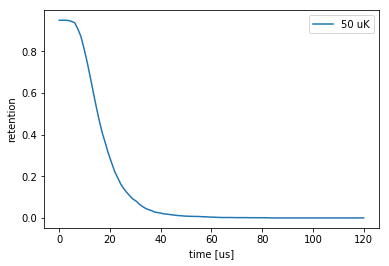

In [15]:
w0 = 2.5e-6 # [m]
TFORT = 1.5e-3 # [K]
Tatom = 5e-5 # [K]
tmax = 120 # [us]
drop_recap(w0,TFORT,Tatom,tmax)